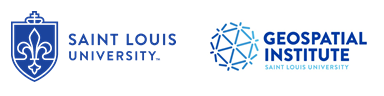

# Assignment 08: Forest Conservation with UNet (Part 1A Preprocessing)
## GIS 5092: Applied Machine Learning for GIS and Remote Sensing (Fall 2021)
Course Instructor: **Dr. Vasit Sagan** (vasit.sagan@slu.edu)
Teaching Assistant: **Sourav Bhadra** (sourav.bhadra@slu.edu)  
[Join Slack Workspace for this class](https://join.slack.com/t/gis5092-fall21/shared_invite/zt-u9vpmzat-SB5sYNtaPWk3vW_Qbj8QRQ)

## Learning Objectives:

* Understand how to process image data for UNet and other segmentation algorithms

# Nothing to Submit for this Notebook

---

In [ ]:
# Make project folder as current working directory
import os
print(os.getcwd())

Z:\gis5092-fall21\assignments\A8_forest_conservation_unet


---

# Data description

# Import modules

In [1]:
import os
import time
import glob
import numpy as np
import pandas as pd
import matplotlib
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
#from skimage.transform import resize
import matplotlib.pyplot as plt

# Pre-process the data

In [1]:
%%time
# Read the data image
src_data = rasterio.open('.\data\WV3_19Feb2019_BNR.tif')
img_data = src_data.read()
img_data_profile = src_data.profile

In [ ]:
%%time
# Read the label image
src_label = rasterio.open('.\data\Bet_LandCover_2019.tif')
img_label = src_label.read()
img_label_profile = src_label.profile

Wall time: 972 ms


In [ ]:
# Read the polygon
polygons= gpd.read_file('.\data\polygon.shp')

In [ ]:
print(img_data.shape)
print(img_label.shape)
print(polygons.shape)

(16, 8097, 8780)
(1, 8097, 8780)
(100, 5)


Define the number of parameters needed to process the data into small patches.

In [ ]:
width = 256
height = 256
n_samples = polygons.shape[0]
n_channels = 16
n_classes= 11

Create two empty arrays that will hold the information about X and y

In [ ]:
X = np.zeros((n_samples, width, height, n_channels))
y = np.zeros((n_samples, width, height, n_classes))

Create your custom one-hot encoding function.

In [ ]:
def label_one_hot(label, width, height, n_classes): 

    # Create an empty numpy array of shape (height x width x n_classes)
    zeros = np.zeros((width, height, n_classes))
    # Get unique index for each class
    index = np.unique(label)  
    
    # For each loop, use that index to create a band (that's the one hot encode)
    for i in index:
        # If label == index (i), then replace True with 1 and False with 0
        onehot_encoded = (label==i).astype(int) 
        # Place one-hot encoded into zeros
        zeros[:, :, int(i)]= onehot_encoded.reshape(width, height)

    return zeros

In a for loop, clip the data image and label image using each feature of the polygon, then store that clipped array into the X and y.

In [ ]:
for i in range(n_samples):
    
    # Get the polygon geometry
    shape_geometry = polygons.iloc[i, -1]
    # Mask the src data image
    data_mask = mask(src_data, [shape_geometry], all_touched=True, crop=True)[0]
    # Move the channel axis to the last dimension
    data_mask = np.moveaxis(data_mask, 0, 2)
    # Resize the array
    data_mask = data_mask[:width, :height, :]
    # Fill the empty np array
    X[i, :, :, :] = data_mask
    
    
    # Mask the src label image
    label_mask = mask(src_label, [shape_geometry], all_touched=True, crop=True)[0]
    # Move the channel axis to the last dimension
    label_mask = np.moveaxis(label_mask, 0, 2)
    # Resize the array
    label_mask = label_mask[:width, :height, :]
    # One hot encode the label
    label_mask_1hot = label_one_hot(label_mask, width, height, n_classes)
    # Fill the empty y np array
    y[i, :, :, :] = label_mask_1hot

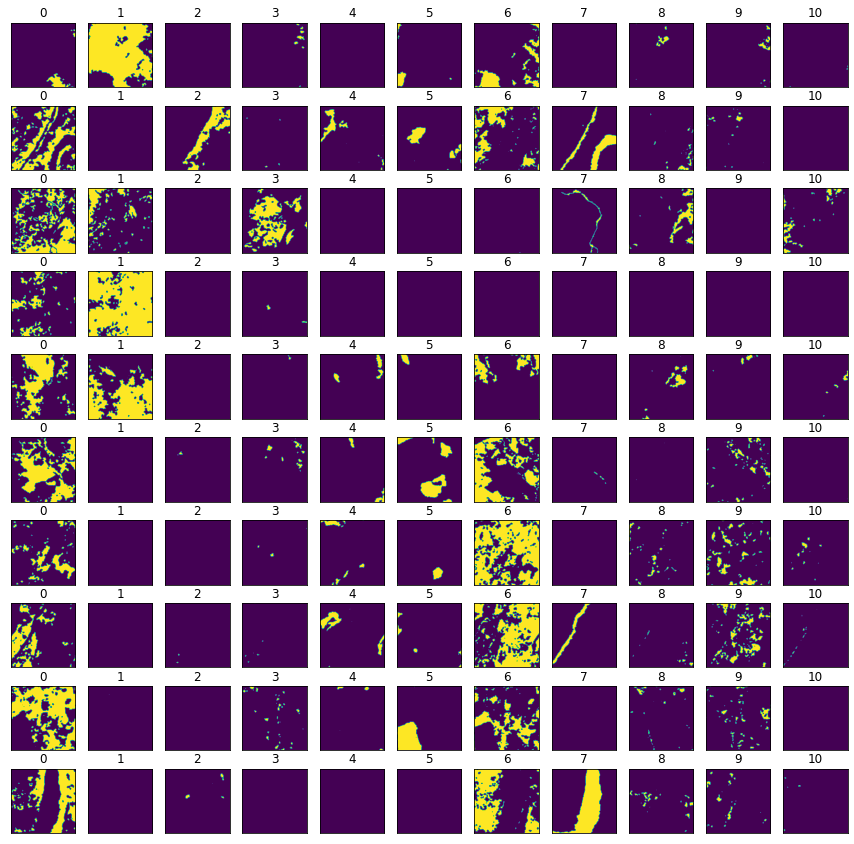

In [ ]:
# visualizing each band within one-hot encoded labels 

fig, ax= plt.subplots(10, 11, figsize=(15, 15))

for i in range(11):
    for j in range(10):
        ax[j, i].imshow(y[j, :, :, i])
        ax[j, i].set_title(i)
        ax[j, i].get_xaxis().set_visible(False)
        ax[j, i].get_yaxis().set_visible(False)

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70, 256, 256, 16)
(30, 256, 256, 16)
(70, 256, 256, 11)
(30, 256, 256, 11)


In [ ]:
np.save(r'X_train.npy', X_train)
np.save(r'X_test.npy', X_test)
np.save(r'y_train.npy', y_train)
np.save(r'y_test.npy', y_test)